In [36]:
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import torch
import random
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        # Patch extaction and representation (layer 1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=0)
        self.relu1 = nn.ReLU(inplace=True)

        # Non-linear mapping (layer 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.relu2 = nn.ReLU(inplace=True)

        # Reconstruction (layer 3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=0)

        #initialize the filters with Gaussian distribution
        self._initialize_weights()


    def _initialize_weights(self):
        init.normal_(self.conv1.weight, mean=0, std=0.001)
        init.normal_(self.conv2.weight, mean=0, std=0.001)
        init.normal_(self.conv3.weight, mean=0, std=0.001)
        init.constant_(self.conv1.bias, 0)
        init.constant_(self.conv2.bias, 0)
        init.constant_(self.conv3.bias, 0)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)
        return x

In [4]:
model = SRCNN()
print(model)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
)


In [28]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, save_interval=10, save_path="model_checkpoint.pth"):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            # calculate MSE loss on the central 20x20 region
            crop_size = 20
            _, _, h, w = outputs.size()
            start_h = (h - crop_size) // 2
            start_w = (w - crop_size) // 2
            outputs_crop = outputs[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]
            targets_crop = targets[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]

            loss = criterion(outputs_crop, targets_crop)

            # backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print the average loss after every epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.10f}')
        
        # Save the model after every 'save_interval' epochs
        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f"{save_path}_epoch_{epoch+1}.pth")
            print(f"Model saved at epoch {epoch+1}.")

In [6]:
criteria = nn.MSELoss()
optimizer = torch.optim.Adam([{'params': model.conv1.parameters(), 'lr': 1e-4},
                              {'params': model.conv2.parameters(), 'lr': 1e-4},
                              {'params': model.conv3.parameters(), 'lr': 1e-5}])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [8]:
# load the images dataset from the disk
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        # lr_dir: path to the low resolution images
        # hr_dir: path to the high resolution images

        self.lr_dir = lr_dir
        self.hr_dir = hr_dir

        #list all the fieles in the directories
        self.lr_images = os.listdir(lr_dir)
        self.hr_images = os.listdir(hr_dir)

        #define the transformation to be applied to the images
        self.transform = transforms.ToTensor()
    
    def __len__(self):
        return len(self.lr_images)
    
    def __getitem__(self, index):
        lr_path = os.path.join(self.lr_dir, self.lr_images[index])
        hr_path = os.path.join(self.hr_dir, self.hr_images[index])

        lr_tensor = self.transform(Image.open(lr_path))
        hr_tensor = self.transform(Image.open(hr_path))

        return lr_tensor, hr_tensor
    
lr_dir = 'sub_images_lr'
hr_dir = 'sub_images_hr'

dataset = ImageDataset(lr_dir, hr_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [29]:
train_model(model, dataloader, criteria, optimizer, num_epochs=100)

"""Below code is to load the model from the saved state"""
# model = SRCNN()  # Make sure to initialize the model first
# checkpoint = torch.load("model_checkpoint_epoch_10.pth")  # Path to the saved model
# model.load_state_dict(checkpoint)


Epoch 1/100, Loss: 0.0001508241
Epoch 2/100, Loss: 0.0001180177
Epoch 3/100, Loss: 0.0000970422
Epoch 4/100, Loss: 0.0000833661
Epoch 5/100, Loss: 0.0000741641
Epoch 6/100, Loss: 0.0000674455
Epoch 7/100, Loss: 0.0000626701
Epoch 8/100, Loss: 0.0000591304
Epoch 9/100, Loss: 0.0000566172
Epoch 10/100, Loss: 0.0000548012
Model saved at epoch 10.
Epoch 11/100, Loss: 0.0000534893
Epoch 12/100, Loss: 0.0000522005
Epoch 13/100, Loss: 0.0000514522
Epoch 14/100, Loss: 0.0000506594
Epoch 15/100, Loss: 0.0000500605
Epoch 16/100, Loss: 0.0000495902
Epoch 17/100, Loss: 0.0000491547
Epoch 18/100, Loss: 0.0000488223
Epoch 19/100, Loss: 0.0000484512
Epoch 20/100, Loss: 0.0000481397
Model saved at epoch 20.
Epoch 21/100, Loss: 0.0000478680
Epoch 22/100, Loss: 0.0000475938
Epoch 23/100, Loss: 0.0000473884
Epoch 24/100, Loss: 0.0000474087
Epoch 25/100, Loss: 0.0000470589
Epoch 26/100, Loss: 0.0000468685
Epoch 27/100, Loss: 0.0000467070
Epoch 28/100, Loss: 0.0000466500
Epoch 29/100, Loss: 0.0000465439
Ep

KeyboardInterrupt: 

In [30]:
def calculate_psnr(original, reconstructed):
    # Compute Peak Signal-to-Noise Ratio (PSNR).
    mse = torch.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse))

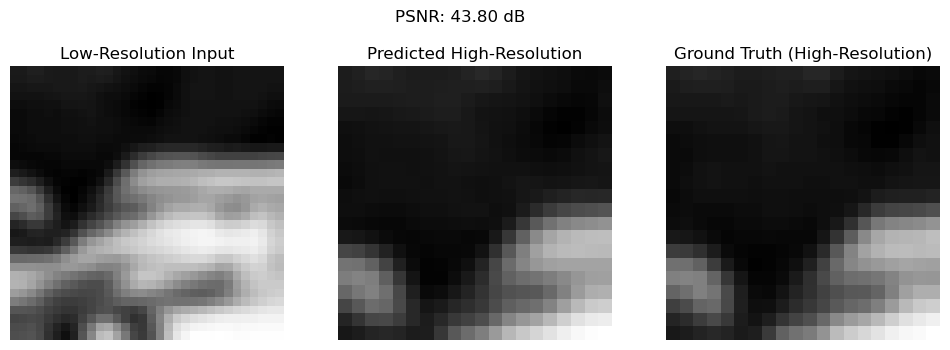

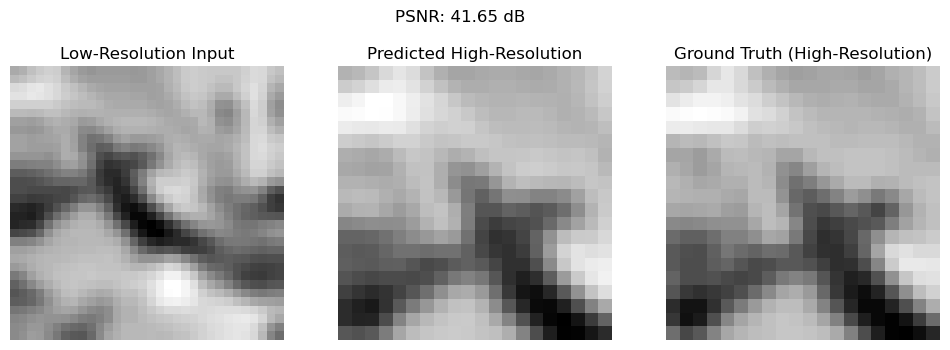

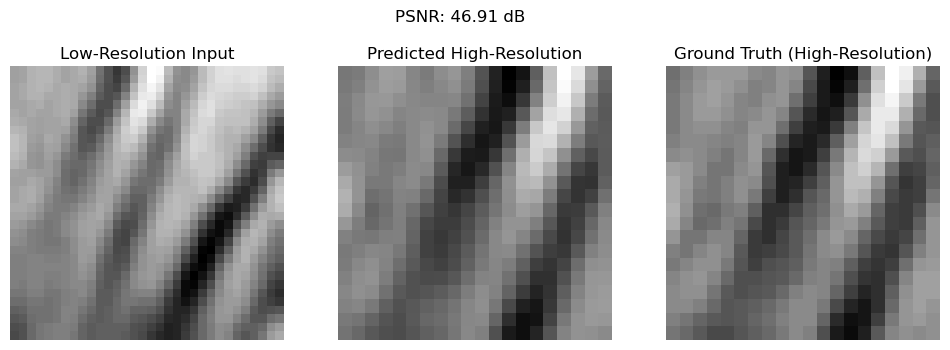

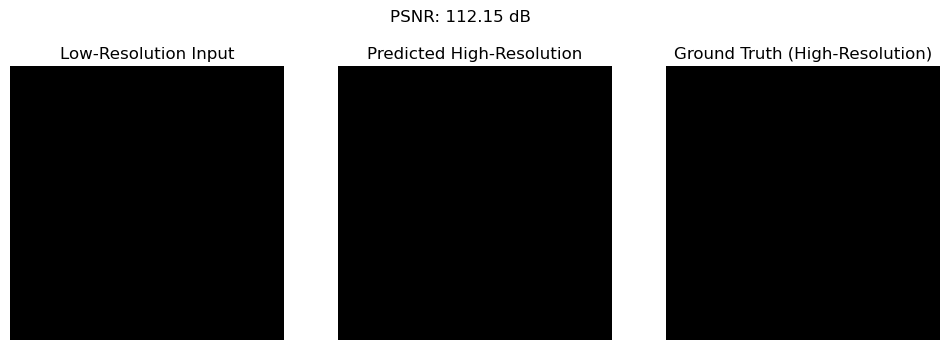

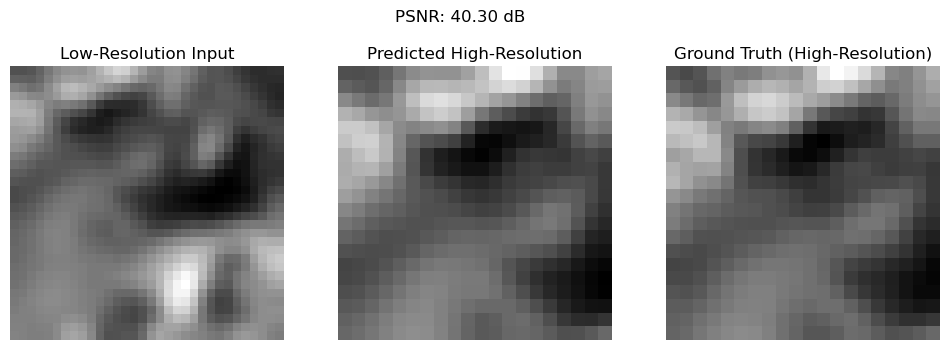

In [31]:
def test_model(model, dataloader, num_images=5):
    """
    Test the SRCNN model on random images from the training or test dataset.
    Args:
        model: Trained SRCNN model.
        dataloader: DataLoader for the dataset.
        num_images: Number of random images to test and display.
    """
    model.eval()
    with torch.no_grad():
        # Convert dataset into a list of samples for random selection
        dataset = dataloader.dataset
        random_indices = torch.randint(0, len(dataset), (num_images,))
        
        for idx in random_indices:
            # Fetch input (low-res) and target (high-res) images
            inputs, targets = dataset[idx]
            inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)
            
            # Pass the input through the model
            outputs = model(inputs)
            
            # Crop the central 20x20 region from outputs and targets
            crop_size = 20
            _, _, h, w = outputs.size()
            start_h = (h - crop_size) // 2
            start_w = (w - crop_size) // 2
            
            outputs_crop = outputs[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]
            targets_crop = targets[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]

            # Compute PSNR
            psnr_value = calculate_psnr(targets_crop, outputs_crop)

            # Convert tensors to numpy arrays for display
            low_res = inputs[0, 0, :, :].cpu().numpy()  # Access the first sample and channel (32x32)
            high_res_pred = outputs_crop[0, 0, :, :].cpu().numpy()  # Crop is (20x20)
            high_res_true = targets_crop[0, 0, :, :].cpu().numpy()  # Crop is (20x20)

            # Display the images
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Low-Resolution Input")
            plt.imshow(low_res, cmap='gray')  # Grayscale image
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Predicted High-Resolution")
            plt.imshow(high_res_pred, cmap='gray')
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Ground Truth (High-Resolution)")
            plt.imshow(high_res_true, cmap='gray')
            plt.axis("off")

            plt.suptitle(f"PSNR: {psnr_value:.2f} dB", fontsize=12)
            plt.show()


test_model(model, dataloader, num_images=5)

In [32]:
def average_psnr(model, dataloader, crop_size=20):
    """
    Calculate the average PSNR over all samples in the dataloader.
    Args:
        model (nn.Module): The trained SRCNN model.
        dataloader (DataLoader): DataLoader for the training or test dataset.
        crop_size (int): The size of the central crop for PSNR calculation.
    Returns:
        float: Average PSNR value.
    """
    model.eval()
    total_psnr = 0.0
    total_images = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Crop the central 20x20 region
            _, _, h, w = outputs.size()
            start_h = (h - crop_size) // 2
            start_w = (w - crop_size) // 2
            outputs_crop = outputs[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]
            targets_crop = targets[:, :, start_h:start_h+crop_size, start_w:start_w+crop_size]

            # Calculate PSNR for each image
            for i in range(outputs_crop.size(0)):  # Iterate through batch
                psnr = calculate_psnr(outputs_crop[i], targets_crop[i])
                total_psnr += psnr
                total_images += 1

    average_psnr_value = total_psnr / total_images
    print(f"Average PSNR over {total_images} samples: {average_psnr_value:.2f} dB")
    return average_psnr_value

In [33]:
average_psnr(model, dataloader)

Average PSNR over 22227 samples: 55.79 dB


55.79436819377645

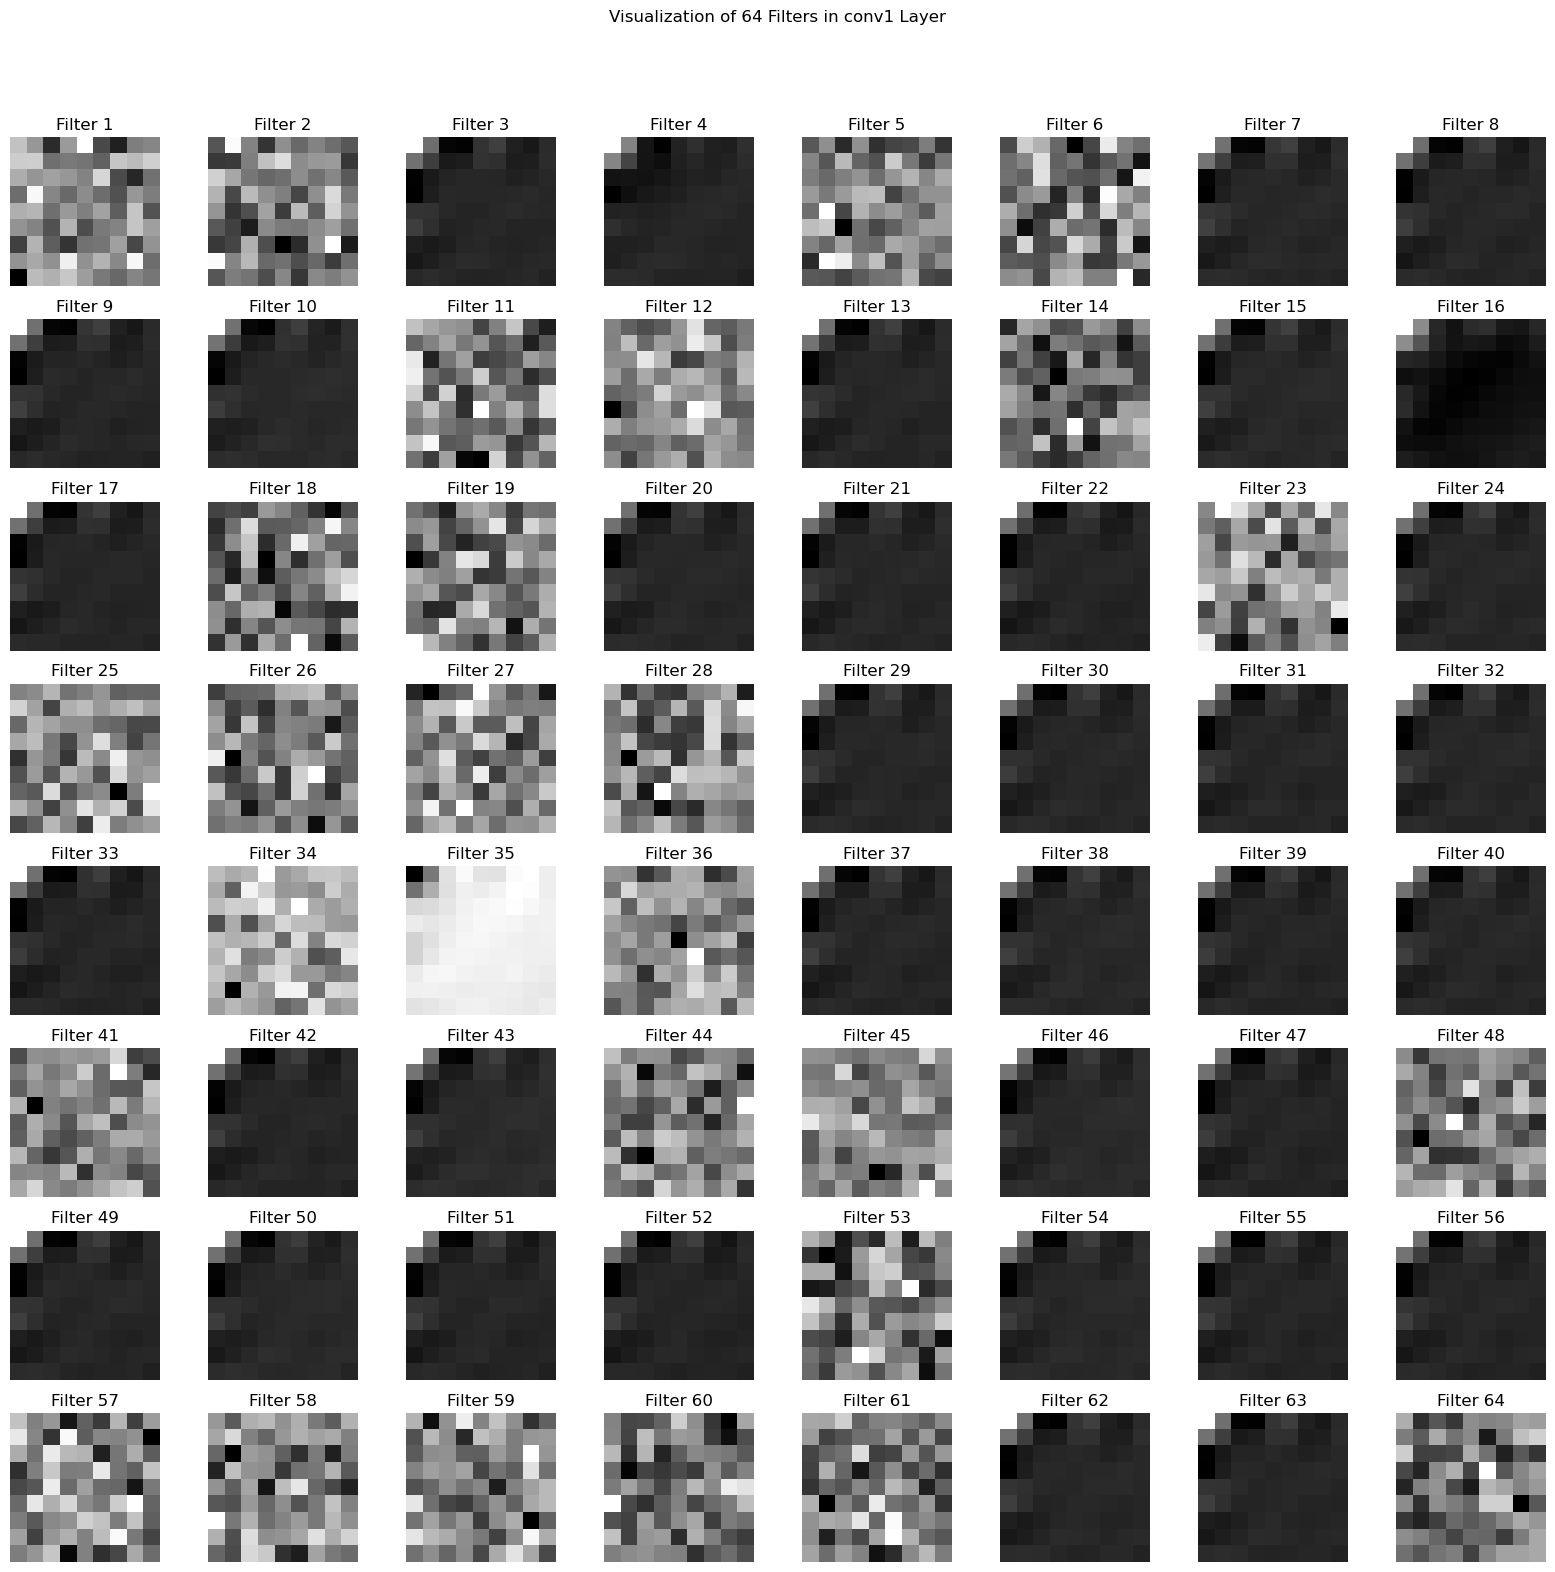

In [34]:
def plot_filters(model, layer_name='conv1', num_cols=8):
    """
    Plot the filters of the first convolutional layer in an 8x8 grid.
    Args:
        model (nn.Module): Trained SRCNN model.
        layer_name (str): Name of the convolutional layer to visualize filters from.
        num_cols (int): Number of columns in the grid. Default is 8.
    """
    # Get the first convolutional layer filters
    layer = getattr(model, layer_name)
    filters = layer.weight.data.cpu().numpy()  # Shape: (out_channels, in_channels, H, W)

    # Plot the filters (only the first channel since input is grayscale)
    num_filters = filters.shape[0]
    filter_size = filters.shape[2]

    num_rows = (num_filters + num_cols - 1) // num_cols  # Compute the number of rows

    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_filters):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(filters[i, 0, :, :], cmap='gray') 
        plt.axis('off')
        plt.title(f"Filter {i+1}")

    plt.suptitle("Visualization of 64 Filters in conv1 Layer")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_filters(model, layer_name='conv1', num_cols=8)


<Figure size 1200x400 with 0 Axes>

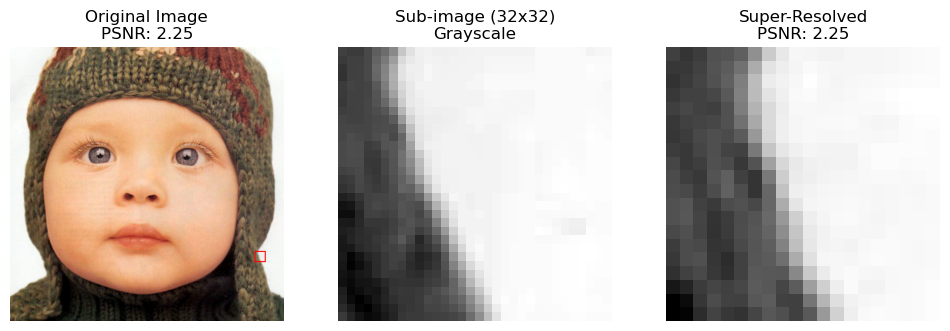

<Figure size 1200x400 with 0 Axes>

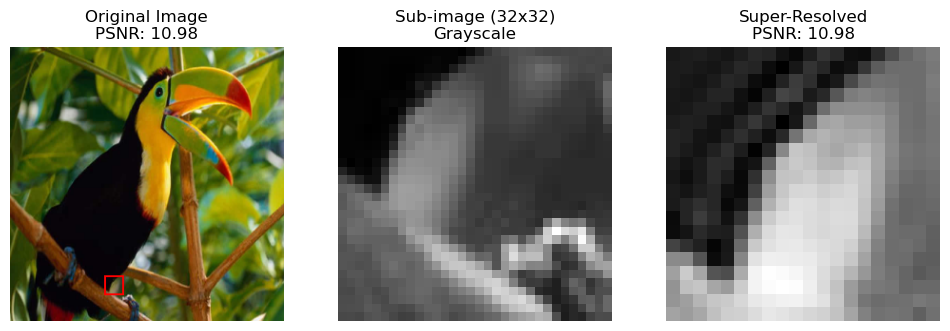

<Figure size 1200x400 with 0 Axes>

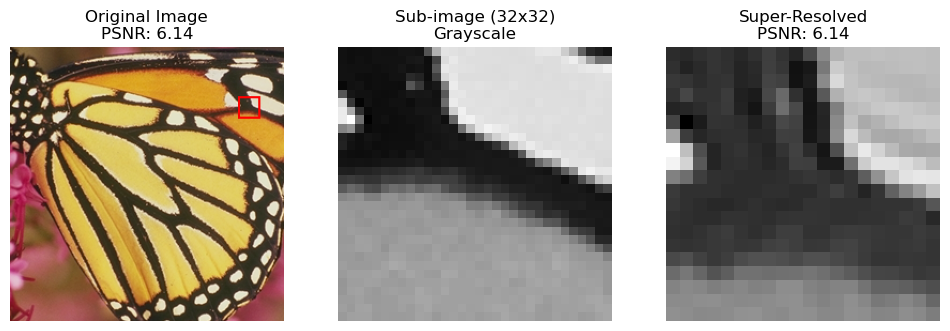

<Figure size 1200x400 with 0 Axes>

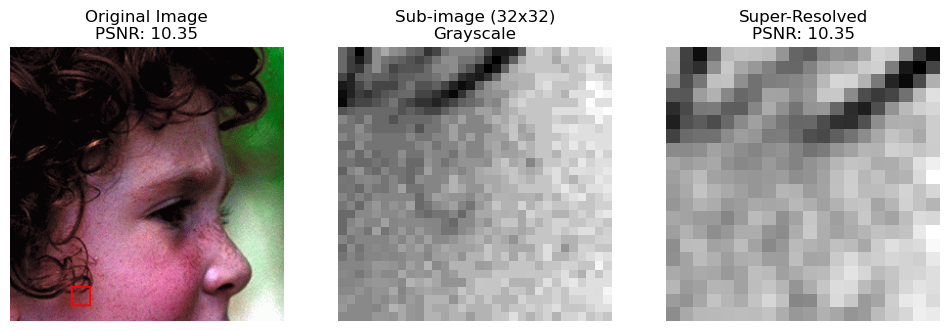

<Figure size 1200x400 with 0 Axes>

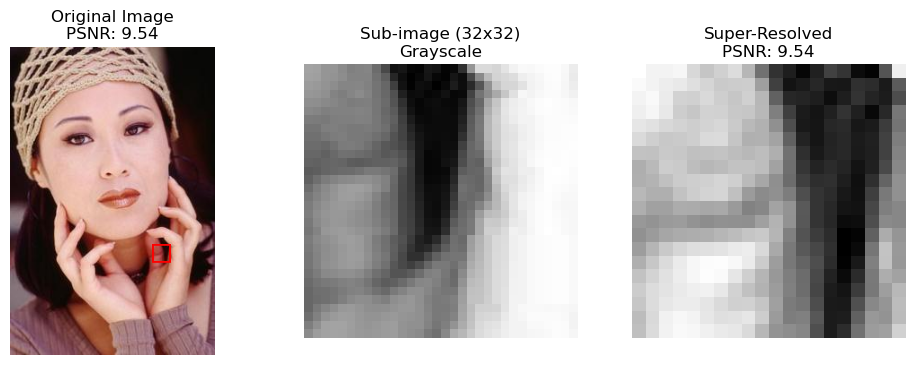

In [49]:
from PIL import Image, ImageDraw

# Function to load image from the file using PIL
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    return image

# Function to crop a 32x32 sub-image from the original image
def crop_sub_image(image, crop_size=32):
    w, h = image.size
    # Crop the random 32x32 region from the image
    left = random.randint(0, w - crop_size)
    top = random.randint(0, h - crop_size)

    # Crop the 32x32 region from the image
    crop_image = image.crop((left, top, left + crop_size, top + crop_size))

    return crop_image, top, left

# Function to process and convert the image to grayscale for SRCNN
def preprocess_image(image):
    # Convert to grayscale
    gray_image = image.convert('L')  # 'L' mode is grayscale
    # Normalize and convert to tensor (ensure values are between 0 and 1)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor_image = transform(gray_image).unsqueeze(0)  # Add batch dimension
    return tensor_image

# Custom PSNR calculation function (based on MSE)
def calculate_psnr(original, reconstructed):
    # Normalize the pixel values to the range [0, 1]
    original = original / 255.0
    reconstructed = reconstructed / 255.0
    
    mse = torch.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse))

# Function to test the model on a set of images and display results
def test_on_set5(model, test_image_dir, device, crop_size=20):
    model.eval()
    with torch.no_grad():
        # List all images in the directory
        image_files = [f for f in os.listdir(test_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        for img_file in image_files:
            image_path = os.path.join(test_image_dir, img_file)
            original_image = load_image(image_path)

            # Get the 32x32 random sub-image from the original image
            sub_image, top, left = crop_sub_image(original_image)

            # Prepare sub-image for super-resolution
            input_tensor = preprocess_image(sub_image).to(device)

            # Apply the SRCNN model to the sub-image
            output_tensor = model(input_tensor)

            # Convert output back to numpy for visualization
            output_image = output_tensor.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and convert to numpy

            # Convert the sub-image (grayscale) to numpy for PSNR calculation
            sub_image_gray = np.array(sub_image.convert('L'))  # Convert to grayscale numpy array

            # Crop both the output and the target (sub_image) to 20x20 before calculating PSNR
            output_crop = output_image[0:crop_size, 0:crop_size]  # Assuming output is single channel
            target_crop = sub_image_gray[0:crop_size, 0:crop_size]

            # Convert to PyTorch tensors for PSNR calculation
            output_tensor_crop = torch.tensor(output_crop).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
            target_tensor_crop = torch.tensor(target_crop).unsqueeze(0).unsqueeze(0)

            # Compute PSNR between the original 32x32 sub-image and the super-resolved image
            psnr_value = calculate_psnr(target_tensor_crop, output_tensor_crop)

            # Show the results
            plt.figure(figsize=(12, 4))

            # Add a red box to show the region from where the sub-image was cropped
            draw = ImageDraw.Draw(original_image)
            draw.rectangle([left, top, left + crop_size, top + crop_size], outline='red', width=2)

            # Show the results
            plt.figure(figsize=(12, 4))

            # Plot the original image
            plt.subplot(1, 3, 1)
            plt.imshow(original_image)
            plt.title(f"Original Image\nPSNR: {psnr_value:.2f}")
            plt.axis("off")

            # Plot the sub-image (grayscale)
            plt.subplot(1, 3, 2)
            plt.imshow(sub_image_gray, cmap='gray')
            plt.title("Sub-image (32x32)\nGrayscale")
            plt.axis("off")

            # Plot the super-resolved output
            output_crop.resize((crop_size, crop_size))
            plt.subplot(1, 3, 3)
            plt.imshow(output_crop, cmap='gray')
            plt.title(f"Super-Resolved\nPSNR: {psnr_value:.2f}")
            plt.axis("off")

            plt.show()

# Test on Set5 directory (adjust the path to your Set5 folder)
test_on_set5(model, "Set5", device)
